In [1]:
import importlib
import gm_utils

importlib.reload(gm_utils)  # Forces Python to reload the updated gm_utils.py

from gm_utils import visualize_density, sample, geodesic, energy
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
# If latex is installed - for nicer formulas rendering in plots
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

Energy of pf ode trajectory: 0.01919364556670189 theta1 tensor([1., 1.])
theta2 tensor([0.1000, 0.4832])


100%|██████████| 1000/1000 [00:07<00:00, 135.43it/s]


Energy of a geodesic: 0.020134426653385162
Energy of pf ode trajectory: 0.0008107871981337667 theta1 tensor([1., 0.])
theta2 tensor([0.1000, 0.0000])


100%|██████████| 1000/1000 [00:13<00:00, 73.97it/s]


Energy of a geodesic: 0.0005056160152889788
Energy of pf ode trajectory: 0.01919364556670189 theta1 tensor([ 1., -1.])
theta2 tensor([ 0.1000, -0.4832])


100%|██████████| 1000/1000 [00:10<00:00, 95.74it/s]


Energy of a geodesic: 0.020134426653385162


Text(0, 0.5, '$\\mathbf{x}$')

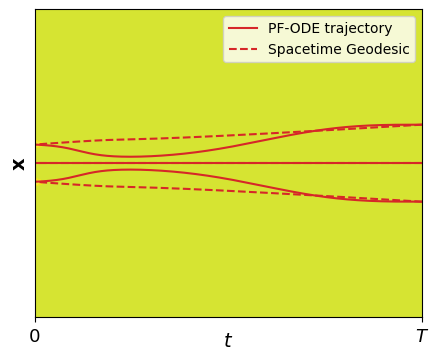

In [2]:
from curves import CubicSpline
import tqdm
import numpy as np
from scipy.interpolate import interp1d
import math 

x_points = np.array([0, 1, 2, 3])
y_points = np.array([0, 2, 4, 6])
f = interp1d(x_points, y_points)

from scipy.optimize import root_scalar
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

original_means = torch.tensor([-0.5, 0.5], dtype=torch.float32) #0,0,0
original_variance = torch.tensor(0.0002, dtype=torch.float32) #0.4
weights = torch.tensor([1/2,1/2], dtype=torch.float32)  #1,0,0

LAMBDA_MIN, LAMBDA_MAX = -20, 20 #min/max logSNR values #-20,20


def log_SNR_cosine(t, s=0.008):
    """Cosine-shaped log-SNR schedule"""
    t_scaled = (t + s) / (1 + s)
    return torch.log(torch.tan(0.5 * torch.pi * (1 - t_scaled)))



def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t


def alpha_sigma(t, T=1.0):
    """
    Forward process parameters for a Variance-Preserving (VP) SDE
    with a *linear-in-noise-variance* schedule..
    """
    sigma2_t = t / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)

    return alpha_t, sigma_t



def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t

def alpha_sigma(t, s=0.008):
    """
    Cosine noise schedule from 'Improved Denoising Diffusion Probabilistic Models' (Nichol & Dhariwal, 2021).

    Args:
        t: torch.Tensor with values in [0, 1]
        s: small offset to avoid singularities (default 0.008)

    Returns:
        alpha_t, sigma_t : tensors of same shape as t
    """
    t = torch.clamp(t, 0.0, 1.0)

    # f(t) = cos^2(((t + s)/(1 + s)) * pi/2)
    f_t = torch.cos(((t + s) / (1 + s)) * math.pi / 2) ** 2

    # use math.cos or a tensor constant to avoid the float→tensor error
    f_0 = math.cos((s / (1 + s)) * math.pi / 2) ** 2

    alpha_t_sq = f_t / f_0
    alpha_t = torch.sqrt(alpha_t_sq)
    sigma_t = torch.sqrt(1.0 - alpha_t_sq)

    return alpha_t, sigma_t

def gaussian_mixture_density(x, t):
    """Analytical implementation of the marginal log-density at time t"""
    alpha_t, sigma_t = alpha_sigma(t)
    means_t = alpha_t[:, None] * original_means[None, :]

    variances_t = sigma_t[:, None]**2 + alpha_t[:, None]**2 * original_variance
    log_probs = torch.log(weights[None, :]) - 0.5 * (torch.log(2 * torch.pi * variances_t) + (x[:, None] - means_t)**2 / variances_t)
    log_p_t = torch.logsumexp(log_probs, dim=1)
    return log_p_t

def visualize_density(ax):
    """Estimates the marginal log-densities and visualizes it as background for the spacetime - used for both Fig1, and Fig5"""
    n_time_points = 50
    n_space_points = 200

    t_vals = torch.linspace(0, 1, n_time_points)
    x_vals = torch.linspace(-4, 4, n_space_points)
    T, X = np.meshgrid(t_vals.numpy(), x_vals.numpy())
    
    T_flat = T.flatten()
    X_flat = X.flatten()
    densities = gaussian_mixture_density(torch.from_numpy(X_flat), torch.from_numpy(T_flat)).reshape(X.shape).detach()
        
    ax.contourf(T, X, (densities).reshape(X.shape), levels=20, cmap='viridis', alpha=0.9)

fig, ax = plt.subplots(figsize=(5, 4))
t_min = 0.1
visualize_density(ax)

def compute_vector_field(x, t):
    """Implementation of the PF-ODE vector field"""
    alpha_t, sigma_t = alpha_sigma(t)
    f_t = 0.5 * (LAMBDA_MIN - LAMBDA_MAX) * sigma_t**2
    g2_t = (LAMBDA_MAX - LAMBDA_MIN) * sigma_t**2
    
    x.requires_grad_(True)
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]
    
    dx = f_t * x - 0.5 * g2_t * grad_log_p_t
    dt = -torch.ones_like(dx)
    return dt.detach().cpu().numpy(), dx.detach().cpu().numpy()

def sample(x, n_steps, t_start=1, t_end=0):
    """PF-ODE sampling"""
    t = t_start * torch.ones_like(x)
    dt_val = (t_start - t_end) / n_steps
    all_x = [x.detach().numpy()]
    all_t = [t.detach().numpy()]
    for i in range(n_steps):
        dt, dx = compute_vector_field(x, t)
        dt, dx = torch.from_numpy(dt), torch.from_numpy(dx)
        x = x + dt * dx * dt_val
        t = t + dt * dt_val
        all_x.append(x.detach().numpy())
        all_t.append(t.detach().numpy())
    return np.array(all_t), np.array(all_x)

def eds(t, x):
    """Implementation of the denoising mean, or Expected Denoised Sample (EDS) - based on Tweedie formula using the score function - Eq61 in the paper"""
    assert t.shape == x.shape
    assert t.ndim == 1
    alpha_t, sigma_t = alpha_sigma(t)    
    x.requires_grad_(True)
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]
    res = (x + sigma_t ** 2 * grad_log_p_t)
    res = res / alpha_t
    return res

def mu(theta):
    """
    Implementation of the expectation parameter - Eq 22 in the paper. Since our data distribution is 1D, the spacetime is 2D
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    mu_t : torch.Tensor
        `time` component of the expectation parameter - tensor or shape (N,)
    mu_x : torch.Tensor
        `space` component of the expectation parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    x.requires_grad_(True)
    f = eds(t, x)
    div = torch.autograd.grad(f.sum(), x, create_graph=True)[0] # In 1D the divergence is just the derivative
    mu_t, mu_x = sigma_t ** 2 / alpha_t * div + f ** 2, f
    return mu_t, mu_x

def eta(theta):
    """
    Implementation of the natural parameter - Eq 18 in the paper.
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    eta_t : torch.Tensor
        `time` component of the natural parameter - tensor or shape (N,)
    eta_x : torch.Tensor
        `space` component of the natural parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    return -0.5 * alpha_t**2/sigma_t**2, alpha_t/sigma_t**2 * x




def energy(theta):
    """
    Implementation of the energy of a discretized curve - Eq 23 in the paper.
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    energy : torch.Tensor
        Energy represented as tensor of shape (,)
    """
    mu_t, mu_x = mu(theta)
    eta_t, eta_x = eta(theta)
    energies = (mu_t[1:] - mu_t[:-1]) * (eta_t[1:] - eta_t[:-1]) + (mu_x[1:] - mu_x[:-1]) * (eta_x[1:] - eta_x[:-1])
    return energies.sum()

def geodesic(theta1, theta2, n_opt_steps, num_intermediate_points, num_nodes=2):
    """
    Implementation of approximate geodesic, parametrizes the curve as a CubicSpline and minimizes its energy w.r.t. curve's parameters using Adam optimizer
    Parameters
    ----------
    theta1: torch.Tensor
        First endpoint of the curve, represented as a point in spacetime, i.e. (2,) tensor
    theta2: torch.Tensor
        Second endpoint of the curve, represented as a point in spacetime, i.e. (2,) tensor
    n_opt_steps : int
        Number of optimization steps
    num_intermediate_points : int
        Number of points to discretize the curve into (in the paper: `N`)
    num_nodes : int
        Parameter of the CubicSpline. The higher the number of nodes, the more flexible/expressive the curve
    """
    curve = CubicSpline(begin=theta1, end=theta2, num_nodes=num_nodes)
    optimizer = torch.optim.Adam(curve.parameters(), lr=1e-1)
    t_tensor = torch.linspace(0, 1, num_intermediate_points).unsqueeze(0)
    for step_id in tqdm.tqdm(range(n_opt_steps)):
        optimizer.zero_grad()
        theta = curve(t_tensor)[0]
        loss = energy(theta)
        loss.backward()
        optimizer.step()
    return curve(t_tensor)[0].detach().numpy()



def score_function(x, t):
    """Gradient of log p_t(x) w.r.t. x (the score)."""
    x = torch.tensor([x], dtype=torch.float32, requires_grad=True)
    t = torch.tensor([t], dtype=torch.float32)
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x)[0]
    return grad_log_p_t.item()


import torch

def score_xt_given_x0(x0, xt, t):
    """
    Compute ∇_{x_t} log p(x0 | x_t).
    
    Parameters
    ----------
    x0 : torch.Tensor
        Ground-truth x0 (shape (B,) or scalar).
    xt : torch.Tensor
        Noisy sample at time t (shape (B,) or scalar).
    t : torch.Tensor or float
        Time(s) in [0,1].
    
    Returns
    -------
    score : torch.Tensor
        Gradient wrt x_t, same shape as xt.
    """
    # ensure tensors
    x0 = torch.as_tensor(x0, dtype=torch.float32)
    xt = torch.as_tensor(xt, dtype=torch.float32)
    t = torch.as_tensor(t, dtype=torch.float32)

    # get α_t, σ_t
    alpha_t, sigma_t = alpha_sigma(t)
    sigma2_t = sigma_t**2

    # gradient wrt xt
    score = -(xt - alpha_t * x0) / sigma2_t
    return score



def find_fixed_points(t, x_min=-4, x_max=4, n_intervals=200):
    """
    Find roots of score_function(x, t) by scanning intervals
    and applying root_scalar.
    """
    xs = np.linspace(x_min, x_max, n_intervals)
    vals = [score_function(x, t) for x in xs]

    roots = []
    for i in range(len(xs)-1):
        if vals[i] == 0:
            roots.append(xs[i])
        elif vals[i] * vals[i+1] < 0:
            try:
                sol = root_scalar(lambda x: score_function(x, t), bracket=[xs[i], xs[i+1]])
                if sol.converged:
                    roots.append(sol.root)
            except ValueError:
                pass
    return np.array(roots)



def plot_ode_geodesics(points):

    for i, x in enumerate(points):
        pf_ode_sample = sample(x, 512, t_start=1., t_end=t_min)
        pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
        print('Energy of pf ode trajectory:', energy(pf_ode_theta).item(), end=' ')
        theta1 = pf_ode_theta[0]
        theta2 = pf_ode_theta[-1]
        print('theta1', theta1)
        print('theta2', theta2)
        #theta1 = torch.tensor([0.00001, 2.2128]) #(theta=(t, x))
        #theta2 = torch.tensor([0.9999, 3.5])
        shortest_path12 = geodesic(theta1, theta2, n_opt_steps=1000, num_intermediate_points=128, num_nodes=2)
        print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())
        if i == 0:
            label_pf = 'PF-ODE trajectory'
            label_g = 'Spacetime Geodesic'
        else:
            label_pf = None
            label_g = None
        ax.plot(pf_ode_theta[:, 0], pf_ode_theta[:, 1], color='C3', label=label_pf)
        ax.plot(shortest_path12[:, 0], shortest_path12[:, 1], color='C3', linestyle='--', label=label_g)


plot_ode_geodesics(torch.tensor([[1.], [0.], [-1]]))

ax.legend()
ax.set_xlim((t_min, 1))
ax.set_xticks([t_min, 1], [r'$0$', r'$T$'], fontsize=13)
ax.set_yticks([])
ax.set_xlabel(r'$t$', fontsize=14, labelpad=-10)
ax.set_ylabel(r'$\mathbf{x}$', fontsize=14)

In [4]:
# Small dataset: all black or all white 16x16 images
img_size = 16
train_images = torch.stack([
    torch.zeros((1, img_size, img_size)),
    torch.ones((1, img_size, img_size))
])  # shape (2, 1, H, W)


In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------
# Dataset
# -----------------------
img_size = 16
train_images = torch.stack([
    torch.zeros((1, img_size, img_size)),  # black
    torch.ones((1, img_size, img_size))    # white
])  # shape (2,1,H,W)

# -----------------------
# Model with periodic BC
# -----------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

class LocalScoreCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: 2 channels (image + time map)
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1, padding_mode='circular')
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1, padding_mode='circular')
        self.conv4 = nn.Conv2d(16, 1, 3, padding=1, padding_mode='circular')
        self.activation = nn.ReLU()

    def forward(self, x, t):
        # ensure batch dimension
        if x.ndim == 3:
            x = x.unsqueeze(0)
        elif x.ndim == 2:
            x = x.unsqueeze(0).unsqueeze(0)

        # ensure t is tensor
        if not torch.is_tensor(t):
            t = torch.tensor([t], dtype=x.dtype, device=x.device)
        if t.ndim == 0:
            t = t.view(1)

        # expand t to spatial map
        t_map = t.view(-1, 1, 1, 1).expand(x.shape[0], 1, x.shape[2], x.shape[3])
        x_in = torch.cat([x, t_map], dim=1)

        # forward pass
        h = self.activation(self.conv1(x_in))
        h = self.activation(self.conv3(h))
        out = self.conv4(h)
        return out


# -----------------------
# Diffusion noise helpers
# -----------------------
def alpha_bar(t, beta_min=0.1, beta_max=20.0):
    """
    Continuous-time linear VP schedule for diffusion models.
    Produces a monotonically decreasing alpha_bar(t) ∈ (0,1].
    """
    beta_t = beta_min + t * (beta_max - beta_min)
    integrated_beta = beta_min * t + 0.5 * (beta_max - beta_min) * t**2
    return torch.exp(-0.5 * integrated_beta)

# -----------------------
# Forward process q(x_t | x_0)
# -----------------------
def q_sample(x0, t):
    """
    Adds Gaussian noise according to the diffusion forward process.
    x0: clean image tensor
    t: scalar or tensor in [0, 1]
    """
    ab = alpha_bar(t)
    noise = torch.randn_like(x0)
    return torch.sqrt(ab).view(-1,1,1,1)*x0 + torch.sqrt(1 - ab).view(-1,1,1,1)*noise

# -----------------------
# Training
# -----------------------
score_model = LocalScoreCNN()
optimizer = torch.optim.Adam(score_model.parameters(), lr=1e-4)
n_epochs = 5000

for epoch in range(n_epochs):
    x0 = train_images[torch.randint(0, len(train_images), (1,))].clone()  # (1,1,H,W)
    t = torch.rand(1)
    xt = q_sample(x0, t)
    alpha, sigma = alpha_sigma(t)

    alpha, sigma = alpha_sigma(t)
    alpha = alpha.view(-1, 1, 1, 1)
    sigma = sigma.view(-1, 1, 1, 1)
    target_score = -(xt - alpha * x0) / (sigma ** 2)
    pred_score = score_model(xt, t)

    loss = F.mse_loss(pred_score, target_score)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.6f}")


Epoch 0: loss = 12.150694
Epoch 100: loss = 39.326019
Epoch 200: loss = 0.950042
Epoch 300: loss = 0.160015
Epoch 400: loss = 349.565063
Epoch 500: loss = 1.517944
Epoch 600: loss = 523006.812500
Epoch 700: loss = 0.221210
Epoch 800: loss = 0.246257
Epoch 900: loss = 3.491891
Epoch 1000: loss = 0.561731
Epoch 1100: loss = 0.252729
Epoch 1200: loss = 0.528358
Epoch 1300: loss = 0.764193
Epoch 1400: loss = 20.338186
Epoch 1500: loss = 4.689816
Epoch 1600: loss = 13.827524
Epoch 1700: loss = 0.437361
Epoch 1800: loss = 5.705308
Epoch 1900: loss = 0.279691
Epoch 2000: loss = 0.267128
Epoch 2100: loss = 0.347096
Epoch 2200: loss = 1.059090
Epoch 2300: loss = 3862.595947
Epoch 2400: loss = 0.279890
Epoch 2500: loss = 0.284597
Epoch 2600: loss = 0.223365
Epoch 2700: loss = 0.279958
Epoch 2800: loss = 1.010710
Epoch 2900: loss = 115.130699
Epoch 3000: loss = 0.330420
Epoch 3100: loss = 0.404522
Epoch 3200: loss = 0.347775
Epoch 3300: loss = 0.424870
Epoch 3400: loss = 1766.317749
Epoch 3500: l

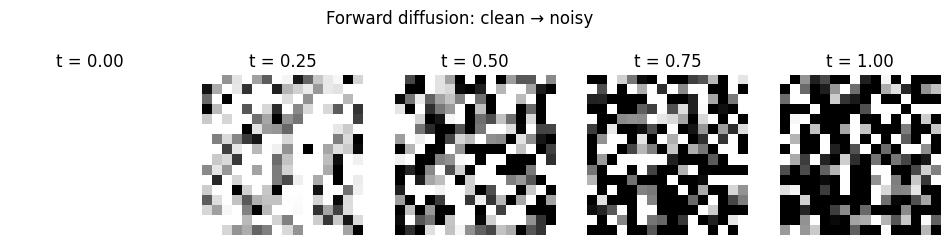

In [62]:
x0 = train_images[1].unsqueeze(0)  # shape (1,1,H,W)

# choose noise levels
ts = torch.linspace(0, 1, steps=5)  # t = 0.0, 0.25, 0.5, 0.75, 1.0

# generate noisy versions
noisy_imgs = [q_sample(x0, t) for t in ts]

# plot them
fig, axes = plt.subplots(1, len(ts), figsize=(12, 3))
for ax, img, t in zip(axes, noisy_imgs, ts):
    ax.imshow(img[0, 0].detach(), cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"t = {t.item():.2f}")
    ax.axis('off')

plt.suptitle("Forward diffusion: clean → noisy", fontsize=12)
plt.show()

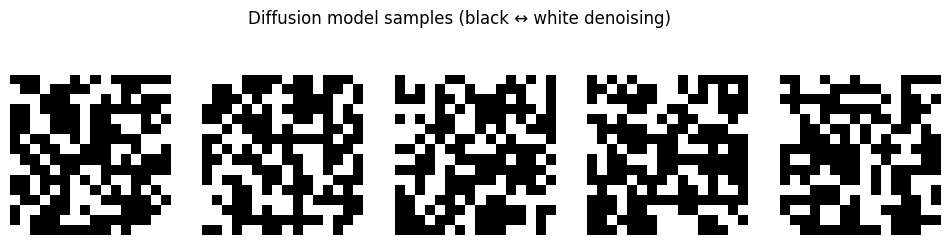

In [68]:
import matplotlib.pyplot as plt
import torch
import matplotlib
matplotlib.rcParams['text.usetex'] = False


# -----------------------
# Sampling function
# -----------------------
def pf_ode_sample(score_model, shape, n_steps=50000):
    x = torch.randn(shape)
    for i in range(n_steps):
        t = torch.tensor([1 - i / n_steps])
        alpha, sigma = alpha_sigma(t)
        with torch.no_grad():
            s = score_model(x, t)
        x = x - (sigma**2) * s * (1.0 / n_steps)
    return (x > 0.5).float()  # final thresholded sample


# -----------------------
# Plot multiple diffusion samples
# -----------------------
n_samples = 5
fig, axes = plt.subplots(1, n_samples, figsize=(12, 3))

for ax in axes:
    img = pf_ode_sample(score_model, (1, 1, img_size, img_size))
    ax.imshow(img[0, 0].detach(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

plt.suptitle("Diffusion model samples (black ↔ white denoising)", fontsize=12)
plt.show()


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# Dataset: all-black and all-white images
# -----------------------
img_size = 16
base_images = torch.stack([
    torch.zeros((1, img_size, img_size)),
    torch.ones((1, img_size, img_size))
])

# Extract all 3×3 patches (with periodic boundaries)
def extract_patches(imgs, patch=3):
    pad = patch // 2
    imgs = F.pad(imgs, (pad, pad, pad, pad), mode='circular')
    patches = imgs.unfold(2, patch, 1).unfold(3, patch, 1)
    patches = patches.contiguous().view(-1, 1, patch, patch)
    return patches

train_patches = extract_patches(base_images)
print(f"Number of training patches: {len(train_patches)}")  # 512 per image = 1024 total

# -----------------------
# Model with periodic BC
# -----------------------
class LocalScoreCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1, padding_mode='circular')
        self.conv2 = nn.Conv2d(32, 1, 3, padding=1, padding_mode='circular')

    def forward(self, x, t):
        t_map = t.view(-1, 1, 1, 1).expand(x.shape[0], 1, x.shape[2], x.shape[3])
        x_in = torch.cat([x, t_map], dim=1)
        h = F.relu(self.conv1(x_in))
        return self.conv2(h)

score_model = LocalScoreCNN().to(device)

# -----------------------
# Diffusion helpers
# -----------------------
def alpha_sigma(t):
    alpha = torch.sqrt(1 - t)
    sigma = torch.sqrt(t)
    return alpha, sigma

def q_sample(x0, t):
    alpha, sigma = alpha_sigma(t)
    # reshape for broadcasting over (B,1,H,W)
    alpha = alpha.view(-1, 1, 1, 1)
    sigma = sigma.view(-1, 1, 1, 1)
    noise = torch.randn_like(x0)
    return alpha * x0 + sigma * noise


# -----------------------
# Training
# -----------------------
optimizer = torch.optim.Adam(score_model.parameters(), lr=1e-2)
n_epochs = 3000
train_patches = train_patches.to(device)

for epoch in range(n_epochs):
    idx = torch.randint(0, len(train_patches), (32,))
    x0 = train_patches[idx]
    t = torch.rand(32, device=device)
    xt = q_sample(x0, t)
    alpha, sigma = alpha_sigma(t)
    target = -(xt - alpha[:, None, None, None] * x0) / (sigma[:, None, None, None] ** 2)
    pred = score_model(xt, t)
    loss = F.mse_loss(pred, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.6f}")


Number of training patches: 512
Epoch 0: loss = 6.610041
Epoch 200: loss = 0.340391
Epoch 400: loss = 0.998686
Epoch 600: loss = 0.460857
Epoch 800: loss = 0.676433
Epoch 1000: loss = 0.730787
Epoch 1200: loss = 0.665692
Epoch 1400: loss = 3.520108
Epoch 1600: loss = 1.063410
Epoch 1800: loss = 0.500807
Epoch 2000: loss = 1.946434
Epoch 2200: loss = 0.885817
Epoch 2400: loss = 0.326763
Epoch 2600: loss = 0.517004
Epoch 2800: loss = 0.659168


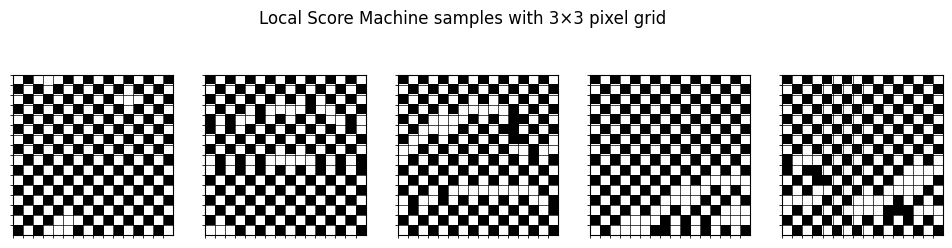

In [39]:
import matplotlib.pyplot as plt

def pf_ode_sample(score_model, shape=(1,1,img_size,img_size), n_steps=200):
    x = torch.randn(shape, device=device)
    for i in range(n_steps):
        t = torch.tensor([1 - i/n_steps], device=device)
        with torch.no_grad():
            s = score_model(x, t)
        x = x - 0.5 * s / n_steps  # local relaxation
    return (x > 0.5).float()

# visualize several samples with a grid
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for ax in axes:
    img = pf_ode_sample(score_model, (1, 1, img_size, img_size))
    ax.imshow(img[0,0].cpu(), cmap='gray', vmin=0, vmax=1)

    # add grid lines
    ax.set_xticks([i-0.5 for i in range(img_size)], minor=True)
    ax.set_yticks([i-0.5 for i in range(img_size)], minor=True)
    ax.grid(which='minor', color='black', linewidth=0.5)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.suptitle("Local Score Machine samples with 3×3 pixel grid", fontsize=12)
plt.show()
